In [1]:
from adversarial_autoencoder import *
aae = AdversarialAutoencoder()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 16)        1216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 60, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        1040      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        8224      
__________

In [2]:
aae.autoencoder.load_weights("autoencoder.h5")

In [3]:
from skimage.io import imread, imshow
import pickle
from sklearn.decomposition import PCA

# svm_clf = pickle.load(open("finalized_model.sav", "rb"))
# X = np.load('embeddings.npy')
# print(X.shape)
# pca = PCA(n_components=3)
# pca.fit(X)

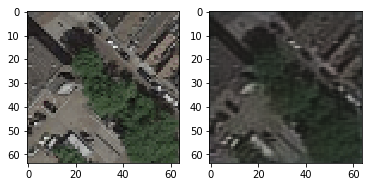

In [9]:
%matplotlib inline
imgs = os.listdir("data/forged_patches")
im = imread("data/forged_path/" + np.random.choice(imgs))
plt.subplot(121)
plt.imshow(im)
if im.shape != (64,64,3):
    pass
im = (im.astype(np.float32)- 175.0) / 175.0
restored = aae.autoencoder.predict(np.expand_dims(im, 0))
restored = 0.5 * restored + 0.5
plt.subplot(122)
plt.imshow(restored[0])

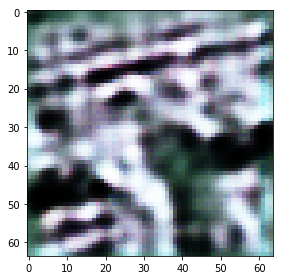

In [29]:
imshow(np.squeeze(restored))

In [ ]:
import os
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            left_x = x if x + windowSize[1] < image.shape[1] else image.shape[1] - windowSize[1]
            right_x = x + windowSize[1] if x + windowSize[1] < image.shape[1] else image.shape[1]
            left_y = y if y + windowSize[0] < image.shape[0] else image.shape[0] - windowSize[0]
            right_y = y + windowSize[0] if y + windowSize[0] < image.shape[0] else image.shape[0]
            yield (left_x, left_y, image[left_y: right_y, left_x: right_x])
                
            
imgs = os.listdir("test_data")
im = imread("test_data/" + np.random.choice(imgs))
print(im.shape)
imshow(im)
mask = np.zeros((640, 640)).astype(np.float32)
print(mask.shape)
for (x, y, patch) in sliding_window(im, 32, (64, 64)):
    patch = patch.astype(np.float32)/255.0
    encoding = aae.adversarial_autoencoder.layers[1].predict(np.expand_dims(patch, 0))
    encoding.resize((1, 2048))
    en_3d = pca.transform(encoding)
    probs = svm_clf.predict_proba(en_3d)
    mask[y:y+64, x:x+64] = np.maximum(mask[y:y+64, x:x+64], np.ones((64,64), dtype=np.float32) * probs[0][0])
    

In [ ]:
imshow(mask)

In [ ]:
X_train = np.load("train_patches.npy")
# X_valid = np.load("valid_patches.npy")

mean = np.mean(X_train, axis=(0, 1, 2, 3))
std = np.std(X_train, axis=(0, 1, 2, 3))

In [ ]:
import os
import cv2
# test_imgs = np.random.choice(os.listdir("forged_patches"), 500)
test_imgs = os.listdir("forged_patches")
pristines = []
stage = len(test_imgs) // 100
cur_stage = 0
for i, idx in enumerate(test_imgs):
    if (i+1) % 100 == 0:
        cur_stage +=1
        
    print("[" + "="*cur_stage + " "*(stage - cur_stage) + "]", end='\r', flush= True)
    im = cv2.imread("forged_patches/" + idx)
    if im.shape != (64,64,3):
        continue
    im = im.astype(np.float32)/255.
    encoding = aae.adversarial_autoencoder.layers[1].predict(np.expand_dims(im, 0))
    encoding = encoding.reshape(2048, 1)
    pristines.append(encoding)

In [ ]:
pristines = np.asarray(pristines)
print(pristines.shape)

In [ ]:
np.save('forged', np.squeeze(pristines))

In [ ]:
aae.autoencoder.summary()